Experimenting with estimating the gender of mailing list participants.

In [1]:
%matplotlib inline

Import the BigBang modules as needed. These should be in your Python environment if you've installed BigBang correctly.

In [77]:
import bigbang.mailman as mailman
import bigbang.graph as graph
import bigbang.process as process
import bigbang.parse as parse
import bigbang.w3crawl as w3crawl
from importlib import reload
reload(parse)
from bigbang.parse import get_date
from bigbang.archive import Archive
import bigbang.utils as utils
import pandas as pd
import datetime
import email
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os
import csv
import re
import scipy
import scipy.cluster.hierarchy as sch
from bigbang import parse
from gender_detector import gender_detector as gd

#pd.options.display.mpl_style = 'default' # pandas has a set of preferred graph formatting options
plt.rcParams['axes.facecolor'] = 'white'
# import seaborn as sns
# sns.set()
# sns.set_style("white")

Now let's load the data for analysis.

In [3]:
urls = ["https://lists.w3.org/Archives/Public/w3c-wai-gl",
"https://lists.w3.org/Archives/Public/public-apa",
"https://lists.w3.org/Archives/Public/public-aria-admin",
"https://lists.w3.org/Archives/Public/public-audio",
"https://lists.w3.org/Archives/Public/public-automotive",
"https://lists.w3.org/Archives/Public/public-browser-tools-testing/",
"https://lists.w3.org/Archives/Public/www-style/",
"https://lists.w3.org/Archives/Public/public-dxwg-wg",
"https://lists.w3.org/Archives/Public/public-device-apis",
"https://lists.w3.org/Archives/Public/w3c-wai-eo/",
"https://lists.w3.org/Archives/Public/public-exi",
"https://lists.w3.org/Archives/Public/public-html-media",
"https://lists.w3.org/Archives/Public/public-i18n-core",
"https://lists.w3.org/Archives/Public/public-poe-wg",
"https://lists.w3.org/Archives/Public/public-pointer-events",
"https://lists.w3.org/Archives/Public/public-data-shapes-wg",
"https://lists.w3.org/Archives/Public/public-secondscreen",
"https://lists.w3.org/Archives/Public/public-socialweb",
"https://lists.w3.org/Archives/Public/public-sdw-wg",
"https://lists.w3.org/Archives/Public/public-svg-wg",
"https://lists.w3.org/Archives/Public/public-tt",
"https://lists.w3.org/Archives/Public/public-tracking",
"https://lists.w3.org/Archives/Public/public-vc-wg",
"https://lists.w3.org/Archives/Public/public-webappsec",
"https://lists.w3.org/Archives/Public/public-webauthn",
"https://lists.w3.org/Archives/Public/public-wot-wg",
"https://lists.w3.org/Archives/Public/public-payments-wg",
"https://lists.w3.org/Archives/Public/public-web-perf",
"https://lists.w3.org/Archives/Public/public-webapps",
"https://lists.w3.org/Archives/Public/public-webrtc",
"https://lists.w3.org/Archives/Public/public-webfonts-wg",
"https://lists.w3.org/Archives/Public/public-xsl-query",
"https://lists.w3.org/Archives/Public/public-xsl-wg",
"https://lists.w3.org/Archives/Public/public-digipub-ig",
"https://lists.w3.org/Archives/Public/public-html-ig-zh",
"https://lists.w3.org/Archives/Public/www-international/",
"https://lists.w3.org/Archives/Public/public-i18n-its-ig/",
"https://lists.w3.org/Archives/Public/public-privacy/",
"https://lists.w3.org/Archives/Public/public-semweb-lifesci/",
"https://lists.w3.org/Archives/Public/w3c-wai-ig/",
"https://lists.w3.org/Archives/Public/public-web-and-tv",
#"https://lists.w3.org/Archives/Public/public-wot-ig", # no archives currently
"https://lists.w3.org/Archives/Public/public-webpayments-ig",
"https://lists.w3.org/Archives/Public/public-web-security"]
#mlists = [(url, mailman.open_list_archives(url,"../archives")) for url in urls[:5]]
mlists = [(url, mailman.open_list_archives(url,"../../w3c-archives")) for url in urls]

/Users/nick/code/anaconda2/envs/bigbang37/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname MET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/Users/nick/code/anaconda2/envs/bigbang37/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/Users/nick/code/anaconda2/envs/bigbang37/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname MDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezo

For each of our lists, we'll clean up the names, find the first name if there is one, and guess its gender. Pandas groups the data together for comparison. We keep count of the names we find that are ambiguous, for the next step.

In [72]:
detector = gd.GenderDetector('us')

gender_ambiguous_names = {}

def guess_gender(name):
    if not name:
        return 'name unknown'
    try:
        if detector.guess(name) == 'unknown':
            if name in gender_ambiguous_names:
                gender_ambiguous_names[name] += 1
            else:
                gender_ambiguous_names[name] = 1
        
        return detector.guess(name)
    except:
        return 'error'

This step will run entity resolution to consolidate based on identical email address or identical cleaned, tokenized name, and then guess gender based on the cleaned name (from From address). This follows the entity resolution steps described in the [IETF participation notebooks](https://github.com/npdoty/bigbang/blob/ietf-participation/ietf-participation/ietf_wgs_tenure.ipynb).

In [70]:
frames = []
for (url, ml) in mlists:
    activity = Archive.get_activity(Archive(ml))
    activityFrame = pd.DataFrame(activity.sum(0), columns=['Message Count'])
        
    activityFrame['Name'] = activityFrame.index.map(lambda x: parse.clean_name(email.utils.parseaddr(x)[0]) or '')   
    
    name_and_email_columns = activityFrame.index.to_series().apply(
    lambda x: pd.Series(
        [x,
         parse.normalize_email_address(email.utils.parseaddr(x)[1]),
         parse.tokenize_name(parse.clean_name(email.utils.parseaddr(x)[0])) or ''],
        index=['from','email','tokenized-name']))
    
    activityFrame = activityFrame.join(name_and_email_columns, how='inner')
    
    email_grouped = activityFrame.groupby('email', as_index=False)

    email_aggregated = email_grouped.aggregate({
        'Message Count': np.sum,
        'Name': lambda x: x.iloc[x.str.len().values.argmax()], # the longest string
        'from': lambda x: x.iloc[x.str.len().values.argmax()], # the longest string
        'tokenized-name': lambda x: x.iloc[x.str.len().values.argmax()]
    })
    
    name_for_matching = email_aggregated['Name'].map(lambda x: x if ' ' in x else None, na_action='ignore')
    
    email_aggregated_no_name_for_matching = email_aggregated[name_for_matching.isnull()].copy(deep=True)
    email_aggregated_for_name_matching = email_aggregated[name_for_matching.notnull()].copy(deep=True)
    name_grouped = email_aggregated_for_name_matching.groupby('Name', as_index=False)

    name_aggregated = name_grouped.aggregate({
        'Message Count': np.sum,
        'from': lambda x: x.iloc[x.str.len().values.argmax()], # the longest string
        'tokenized-name': lambda x: x.iloc[x.str.len().values.argmax()],
        'email': lambda x: x.value_counts().idxmax() # most common email in the group
    })
    
    activityFrame = name_aggregated.append(email_aggregated_no_name_for_matching, ignore_index=True)
    
    activityFrame['First Name'] = activityFrame['Name'].map(lambda x: parse.guess_first_name(x))
    activityFrame['Guessed Gender'] = activityFrame['First Name'].map(guess_gender)
    
    frames.append((url, activityFrame))

In [71]:
frames[0][1]

,Name,Message Count,from,tokenized-name,email,First Name,Guessed Gender
0,=windows-1251Q TomsonQvwm Aaron=,1278.0,=?windows-1251?Q? TomsonQvwm Aaron?= <...,=windows-1251q aaron= tomsonqvwm,charles@w3.org,=windows-1251Q,error
1,ADAM GUASCH-MELENDEZ,5.0,ADAM GUASCH-MELENDEZ <ADAM.GUASCH@EEOC.GOV>,adam guasch-melendez,adam.guasch@eeoc.gov,ADAM,male
2,ALAN SMITH,128.0,ALAN SMITH <alands289@gmail.com>,alan smith,alands289@gmail.com,ALAN,male
3,AUDRAIN LUC,1.0,AUDRAIN LUC <LAUDRAIN@hachette-livre.fr>,audrain luc,laudrain@hachette-livre.fr,AUDRAIN,unknown
4,Aaron Leventhal,1.0,Aaron Leventhal <aaronl@netscape.com>,aaron leventhal,aaronl@netscape.com,Aaron,male
...,...,...,...,...,...,...,...
853,,1.0,win@today.com,,win@today.com,None,name unknown
854,,1.0,wonkai@mailexcite.com,,wonkai@mailexcite.com,None,name unknown
855,,1.0,workshop@npcollege-edu.net,,workshop@npcollege-edu.net,None,name unknown
856,Alice,1.0,Alice <xiaoqian@w3.org>,alice,xiaoqian@w3.org,None,name unknown


In [73]:
series = []  

for (url, activityFrame) in frames:
    counts = activityFrame.groupby('Guessed Gender')['Message Count'].sum()
    participants = activityFrame.groupby('Guessed Gender')['Name'].count()
    
    counts_combined = pd.concat([counts, participants], keys=['message count', 'participants'])
    
    counts_combined.name=url
    series.append(counts_combined)

genderFrame = pd.DataFrame(series)

# filter for lists with at least 100 total messages
genderFrame['message count', 'total'] = genderFrame['message count'].sum(axis=1)
genderFrame = genderFrame[genderFrame['message count', 'total'] > 100]
genderFrame

message count          \
Guessed Gender                                             error  female   
https://lists.w3.org/Archives/Public/w3c-wai-gl           1280.0  5248.0   
https://lists.w3.org/Archives/Public/public-apa              NaN    78.0   
https://lists.w3.org/Archives/Public/public-ari...           NaN    38.0   
https://lists.w3.org/Archives/Public/public-audio            NaN    43.0   
https://lists.w3.org/Archives/Public/public-aut...           NaN    14.0   
https://lists.w3.org/Archives/Public/public-bro...           NaN    22.0   
https://lists.w3.org/Archives/Public/www-style/             98.0   272.0   
https://lists.w3.org/Archives/Public/public-dev...          27.0   174.0   
https://lists.w3.org/Archives/Public/w3c-wai-eo/             NaN   322.0   
https://lists.w3.org/Archives/Public/public-exi              NaN    13.0   
https://lists.w3.org/Archives/Public/public-htm...           1.0    47.0   
https://lists.w3.org/Archives/Public/public-i18...           2.0   103.0   
https://lists.w3.org/Archives/Public/public-poe-wg           NaN    35.0   
https://lists.w3.org/Archives/Public/public-poi...          22.0    16.0   
https://lists.w3.org/Archives/Public/public-dat...           NaN   882.0   
https://lists.w3.org/Archives/Public/public-sec...           NaN     1.0   
https://lists.w3.org/Archives/Public/public-soc...           NaN   186.0   
https://lists.w3.org/Archives/Public/public-sdw-wg           NaN    10.0   
https://lists.w3.org/Archives/Public/public-svg-wg           NaN    18.0   
https://lists.w3.org/Archives/Public/public-tt               NaN   191.0   
https://lists.w3.org/Archives/Public/public-tra...           NaN   511.0   
https://lists.w3.org/Archives/Public/public-web...          21.0   856.0   
https://lists.w3.org/Archives/Public/public-web...           NaN    35.0   
https://lists.w3.org/Archives/Public/public-pay...           7.0    20.0   
https://lists.w3.org/Archives/Public/public-web...           3.0    90.0   
https://lists.w3.org/Archives/Public/public-web...           6.0   547.0   
https://lists.w3.org/Archives/Public/public-webrtc           NaN   153.0   
https://lists.w3.org/Archives/Public/public-xsl...           NaN     8.0   
https://lists.w3.org/Archives/Public/public-xsl-wg           NaN    12.0   
https://lists.w3.org/Archives/Public/public-dig...           1.0   225.0   
https://lists.w3.org/Archives/Public/public-htm...          79.0     7.0   
https://lists.w3.org/Archives/Public/www-intern...          28.0   357.0   
https://lists.w3.org/Archives/Public/public-i18...           NaN     8.0   
https://lists.w3.org/Archives/Public/public-pri...           NaN   241.0   
https://lists.w3.org/Archives/Public/public-sem...           NaN  1298.0   
https://lists.w3.org/Archives/Public/w3c-wai-ig/             NaN   758.0   
https://lists.w3.org/Archives/Public/public-web...          24.0   127.0   
https://lists.w3.org/Archives/Public/public-web...           1.0    65.0   

                                                                          \
Guessed Gender                                         male name unknown   
https://lists.w3.org/Archives/Public/w3c-wai-gl     14882.0       7845.0   
https://lists.w3.org/Archives/Public/public-apa       190.0        443.0   
https://lists.w3.org/Archives/Public/public-ari...    292.0         38.0   
https://lists.w3.org/Archives/Public/public-audio    4601.0       1776.0   
https://lists.w3.org/Archives/Public/public-aut...    543.0        101.0   
https://lists.w3.org/Archives/Public/public-bro...    665.0        965.0   
https://lists.w3.org/Archives/Public/www-style/     15641.0       2241.0   
https://lists.w3.org/Archives/Public/public-dev...   3013.0       2652.0   
https://lists.w3.org/Archives/Public/w3c-wai-eo/      943.0        198.0   
https://lists.w3.org/Archives/Public/public-exi       241.0        185.0   
https://lists.w3.org/Archives/Public/public-htm...   1494.0        738.0   
https://lists.w3.org/A

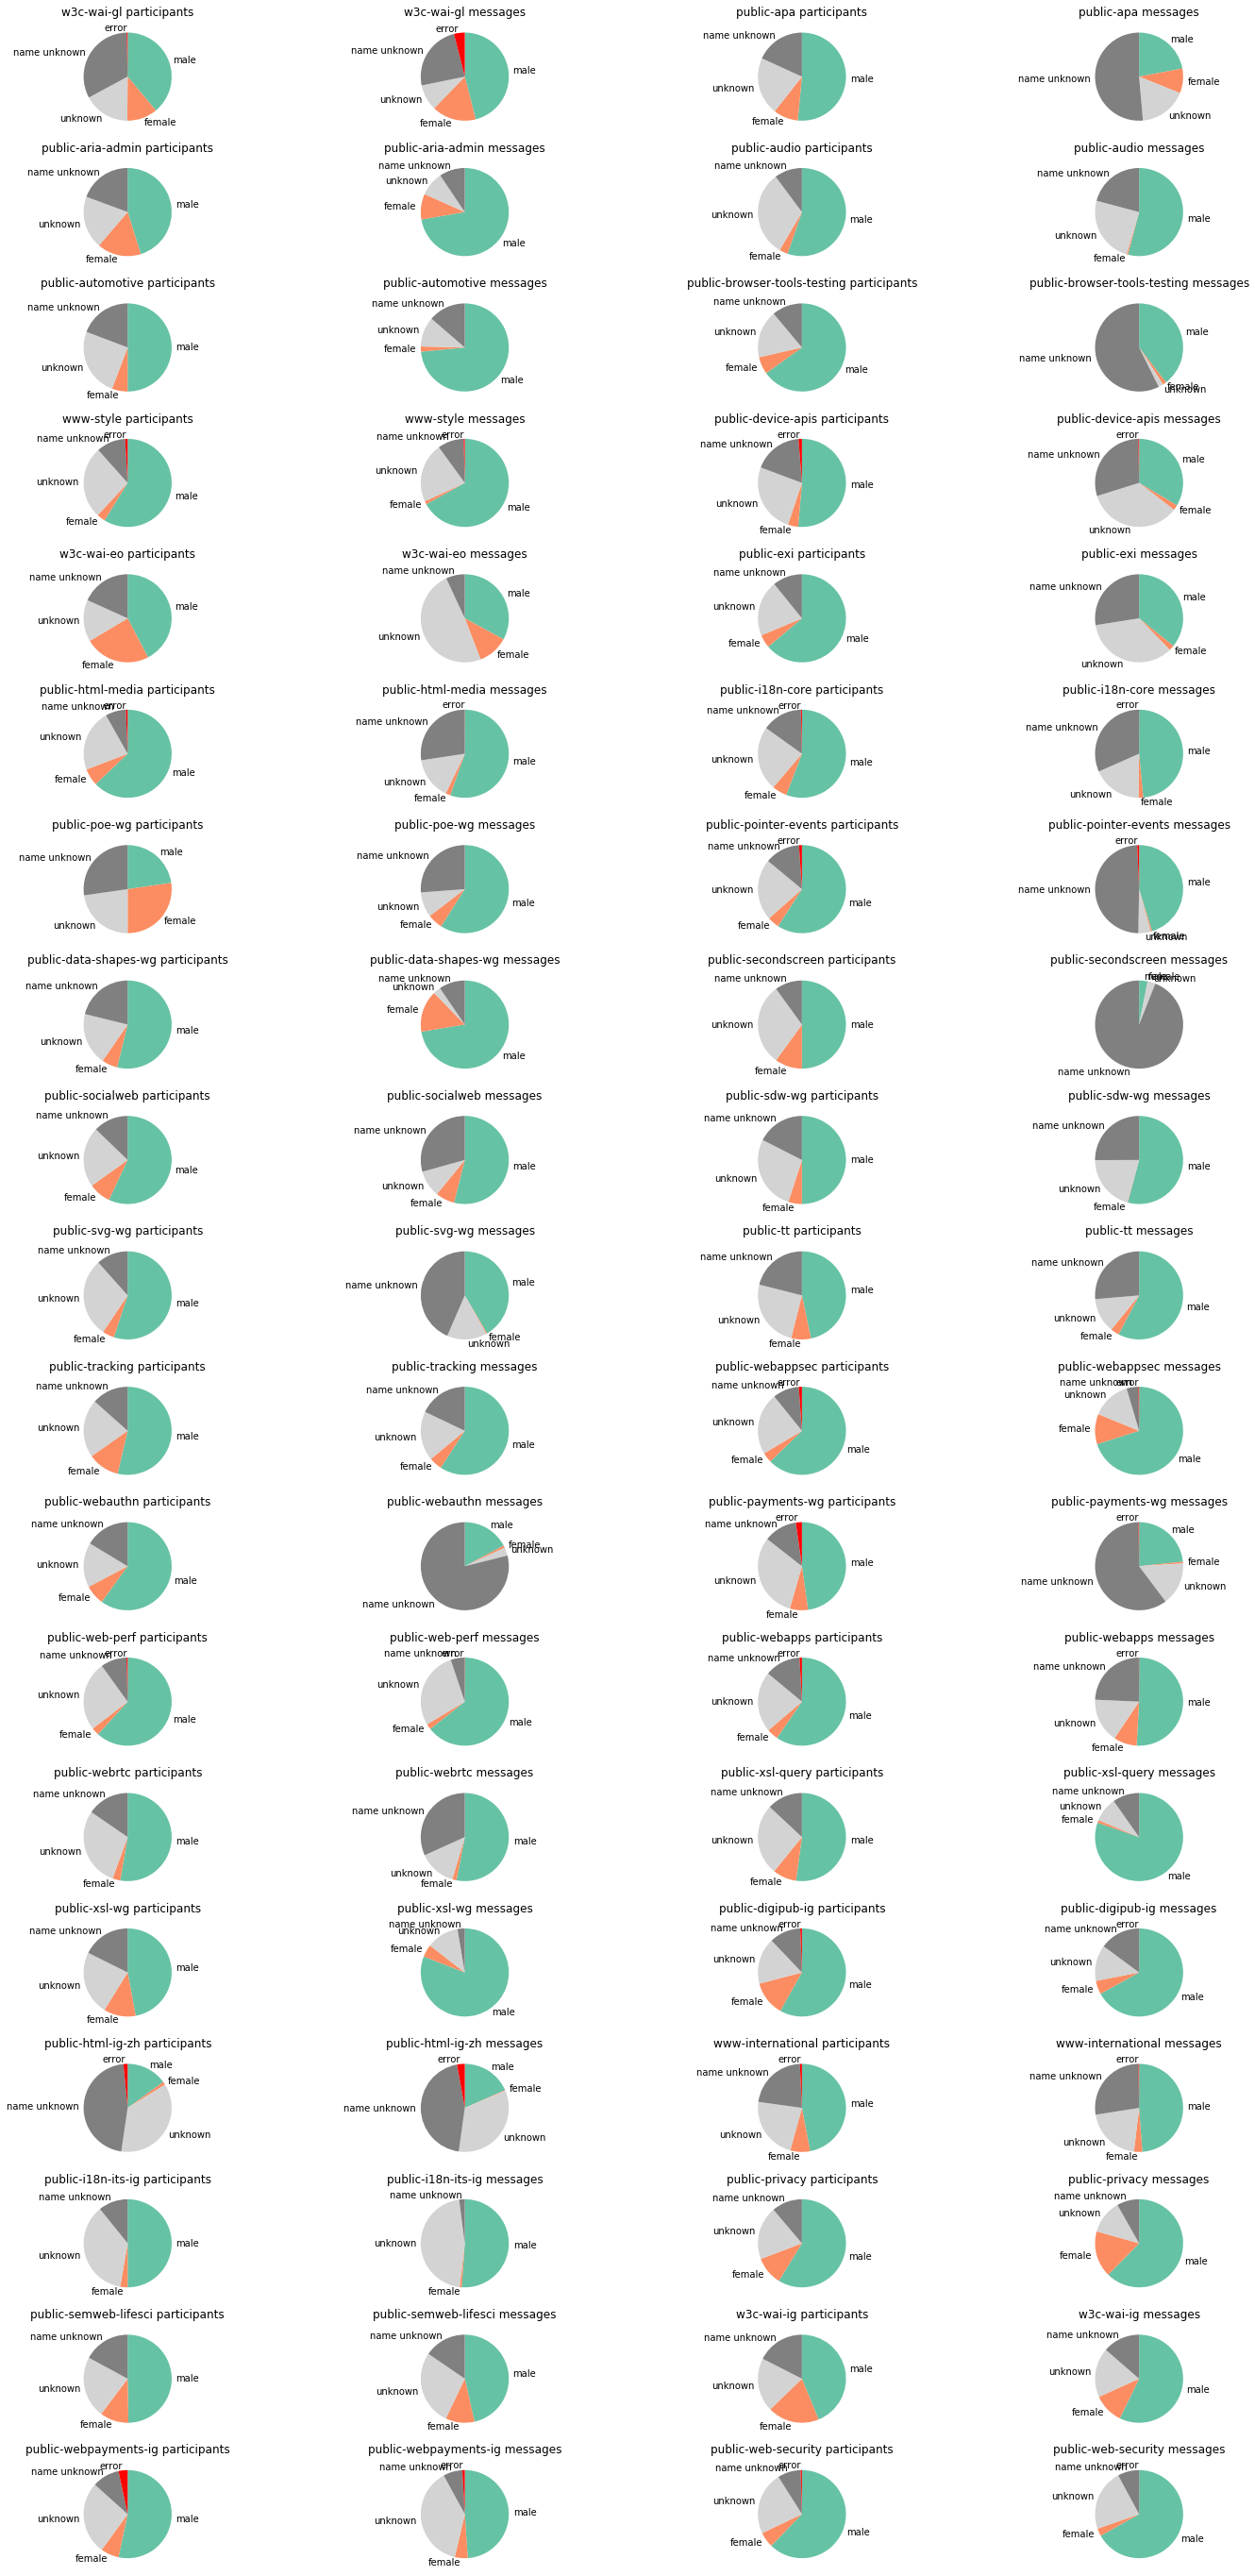

In [83]:
# define consistent colors for each label, avoiding stereotypes, to be consistent across charts
qualitative_color_mapping = {'male':'#66c2a5', 
                             'female':'#fc8d62', 
                             'error':'red', 
                             'unknown':'lightgray', 
                             'name unknown':'gray'}
# from ColorBrewer ['#66c2a5','#fc8d62','#8da0cb'], 
# ... a 3-class qualitative color map that is colorblind friendly and print safe

def colors_for_labels(labels):
    return [qualitative_color_mapping[l] for l in labels]
gender_label_ordering = ['male','female','unknown','name unknown', 'error']

def ml_shortname(url):
    return url.rstrip("/").split("/")[-1]

i = 1
cols = 4
rows = len(genderFrame.index)/2 + 1
fig = plt.figure(figsize=(20,40))

for ind, ser in genderFrame.iterrows():
    ax = plt.subplot(rows, cols, i)
    participants = ser['participants']
    participants = participants.reindex(gender_label_ordering)
    participants.plot(kind='pie', colors=colors_for_labels(participants.index), startangle=90, counterclock=False)
    ax.set_aspect('equal')
    ax.set_title(ml_shortname(ser.name) + ' participants')
    ax.set_ylabel('')
    i+=1

    ax = plt.subplot(rows, cols, i)
    messages = ser['message count']
    messages = messages.reindex(gender_label_ordering)
    messages.plot(kind='pie', colors=colors_for_labels(messages.index), startangle=90, counterclock=False)
    ax.set_aspect('equal')
    ax.set_title(ml_shortname(ser.name) + ' messages')
    ax.set_ylabel('')
    i+=1
    
plt.tight_layout()
plt.savefig('gender-pies.png', facecolor='w')
plt.show()

In [84]:
participants = genderFrame['participants']
participants['male fraction'] = participants['male'] / participants.sum(1)
participants['female fraction'] = participants['female'] / participants.sum(1)
participants['unknown fraction'] = (participants['unknown'] + participants['name unknown']) / participants.sum(1)

participants = participants.reset_index()
participants['shortname'] = participants.apply(lambda x: mailman.get_list_name(x['index']), axis=1)

participants = participants.sort_values(by='female fraction', ascending=False)

/Users/nick/code/anaconda2/envs/bigbang37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/nick/code/anaconda2/envs/bigbang37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nick/code/anaconda2/envs/bigbang37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set o

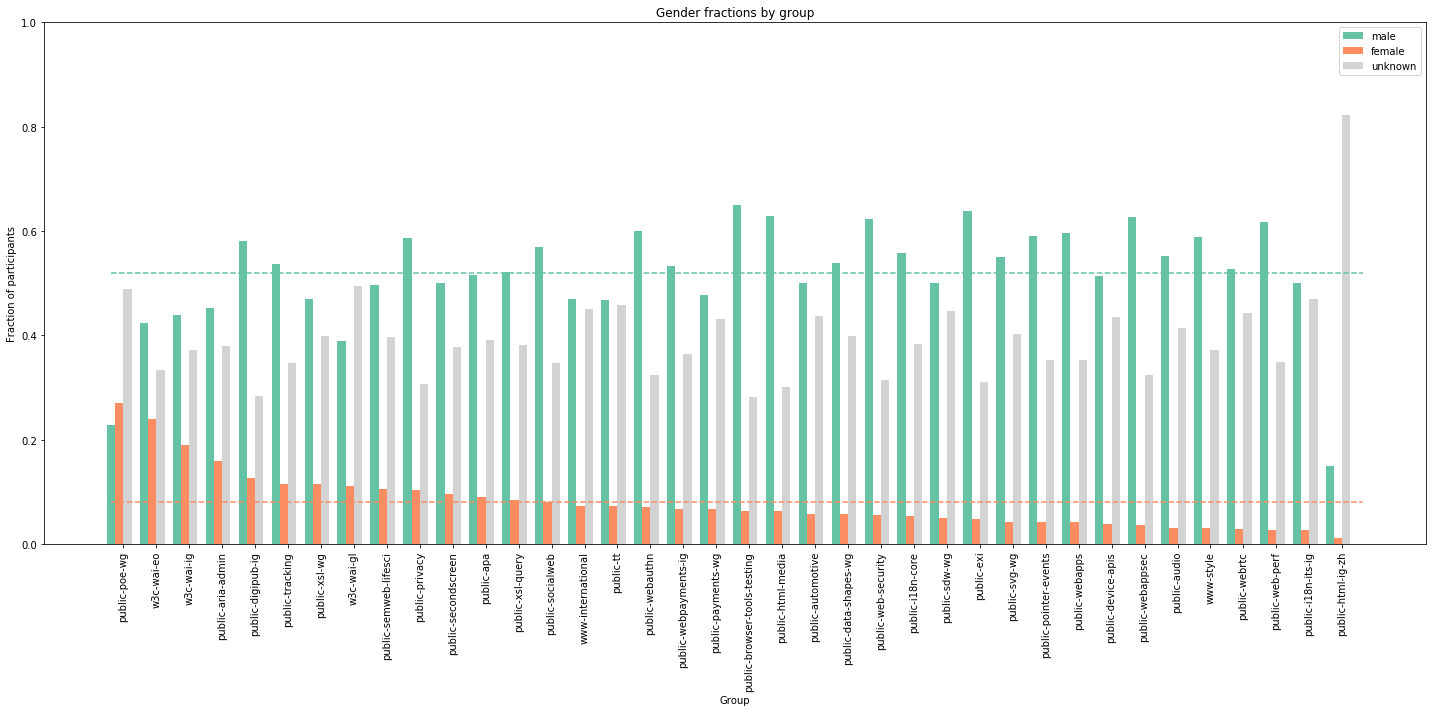

In [86]:
fig = plt.figure(figsize=(20,10))
n_groups = len(participants.index)
index = np.arange(n_groups)
bar_width = 0.25

bar_variables = ['male', 'female', 'unknown']

for (i,value) in zip(range(len(bar_variables)), bar_variables):
    rects1 = plt.bar(index + (bar_width * i), participants[value + ' fraction'], bar_width,
                     color=qualitative_color_mapping[value],
                     label=value)

plt.xlabel('Group')
plt.ylabel('Fraction of participants')
plt.title('Gender fractions by group')
plt.xticks(index + bar_width * 1.5, participants['shortname'], rotation='vertical')
plt.ylim(top=1)

qualitative_color_mapping

plt.hlines([participants['male fraction'].mean(), participants['female fraction'].mean()],
           0, n_groups, 
           colors=[qualitative_color_mapping[x] for x in ['male','female']], 
           linestyles='dashed')
plt.legend()

plt.tight_layout()
#sns.despine()

plt.savefig('gender-fraction-bars.png', facecolor='w')
plt.show()

In [87]:
participants['male fraction'].mean(), participants['female fraction'].mean()

(0.5187102297010577, 0.08009845087453765)